# Scoring Aggregation

Test score aggregation method with synthetic scorings to test edge cases.

## Score aggregation method

- Min-max-normalize scorings
- Compute threshold $t$ for each scoring individually ($2\sigma$-thresholding)
- Zero all scores that are below the threshold $t$
- Compute distance between score and threshold $t$
- Take max over all scorings

In [9]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from pythresh.thresholds.mad import MAD
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from timeeval.metrics.thresholding import PyThreshThresholding

sys.path.append("..")
sys.path.append("../paper-plots")

from autotsad.evaluation import aggregate_scores

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 9)

# Define edge cases

- all 1, but single point 0
- all 0, but single point 1
- very noisy
- all scores align (have the same peaks)


In [3]:
rng = np.random.default_rng(42)
N = 1_000

noise = rng.normal(0, 1, N)
all_1 = np.ones(N, dtype=np.float_)
all_1[rng.integers(0, N, 1)] = 0
all_0 = np.zeros(N, dtype=np.float_)
all_0[rng.integers(0, N, 1)] = 1
score0 = np.genfromtxt("../tmp/baseline-scores/81fd6ddfd412589b08f265325651e2f6-k-Means-d751713988987e9331980363e24189ce.csv", max_rows=N)
score1 = np.genfromtxt("../tmp/baseline-scores/81fd6ddfd412589b08f265325651e2f6-SAND-d751713988987e9331980363e24189ce.csv", max_rows=N)
score2 = np.genfromtxt("../tmp/baseline-scores/81fd6ddfd412589b08f265325651e2f6-stomp-d751713988987e9331980363e24189ce.csv", max_rows=N)

scenarios = [
    np.array([score0, score1, score2]),
    np.array([score0, noise, score1, score2]),
    np.array([score0, all_1, score1, score2]),
    np.array([score0, all_0, score1, score2]),
    np.array([noise, np.roll(noise, 20), np.roll(noise, -413), np.roll(noise, 176)]),
    np.array([noise, 1-score0, score1, noise]),
]

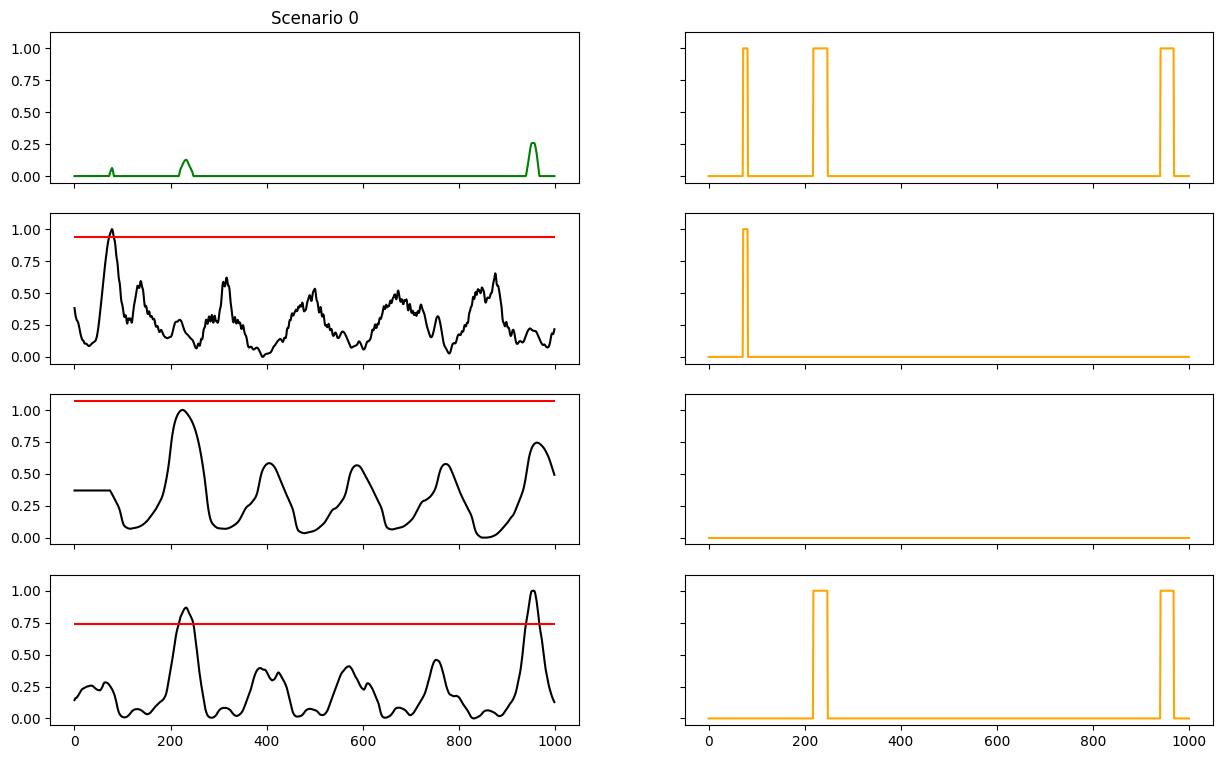

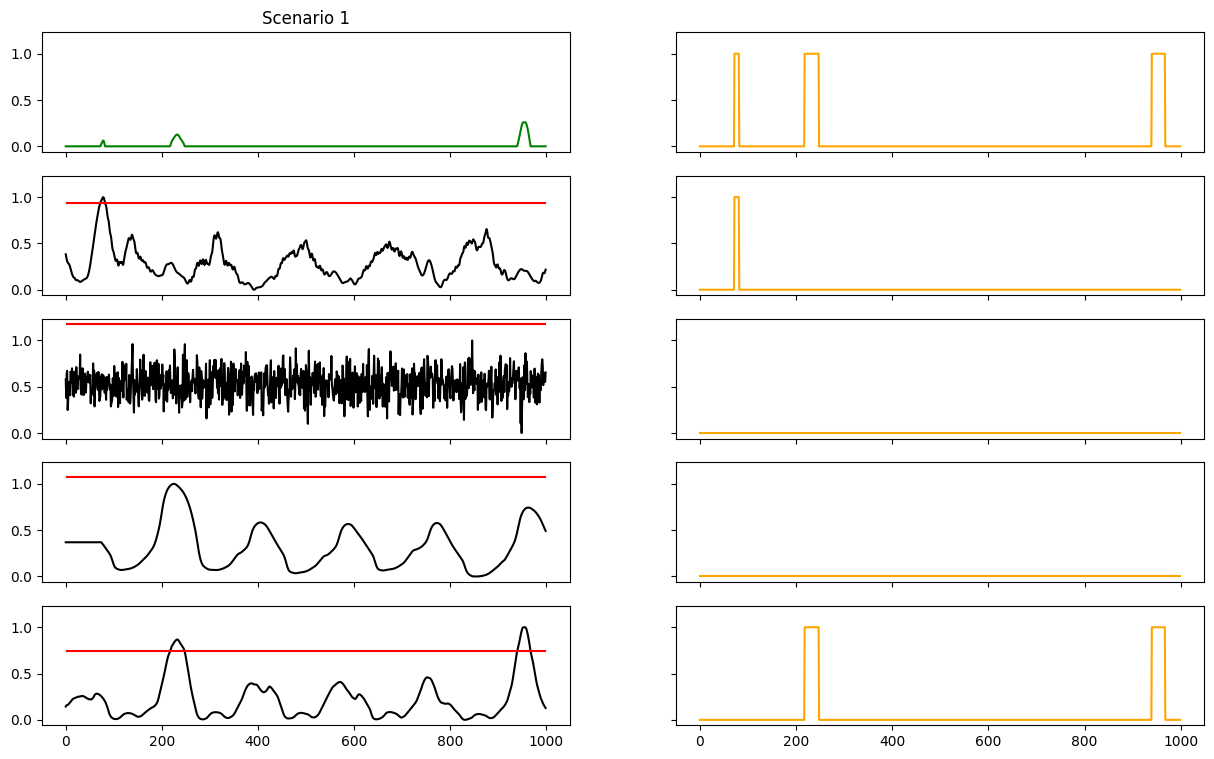

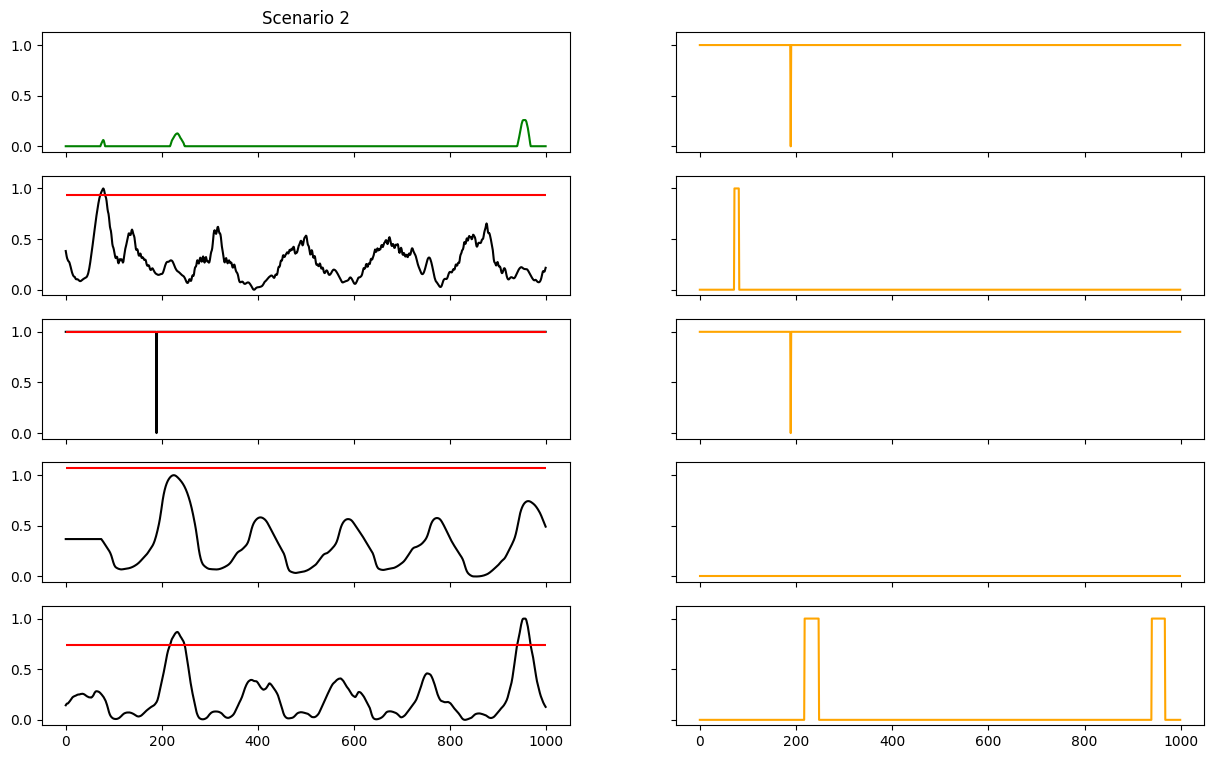

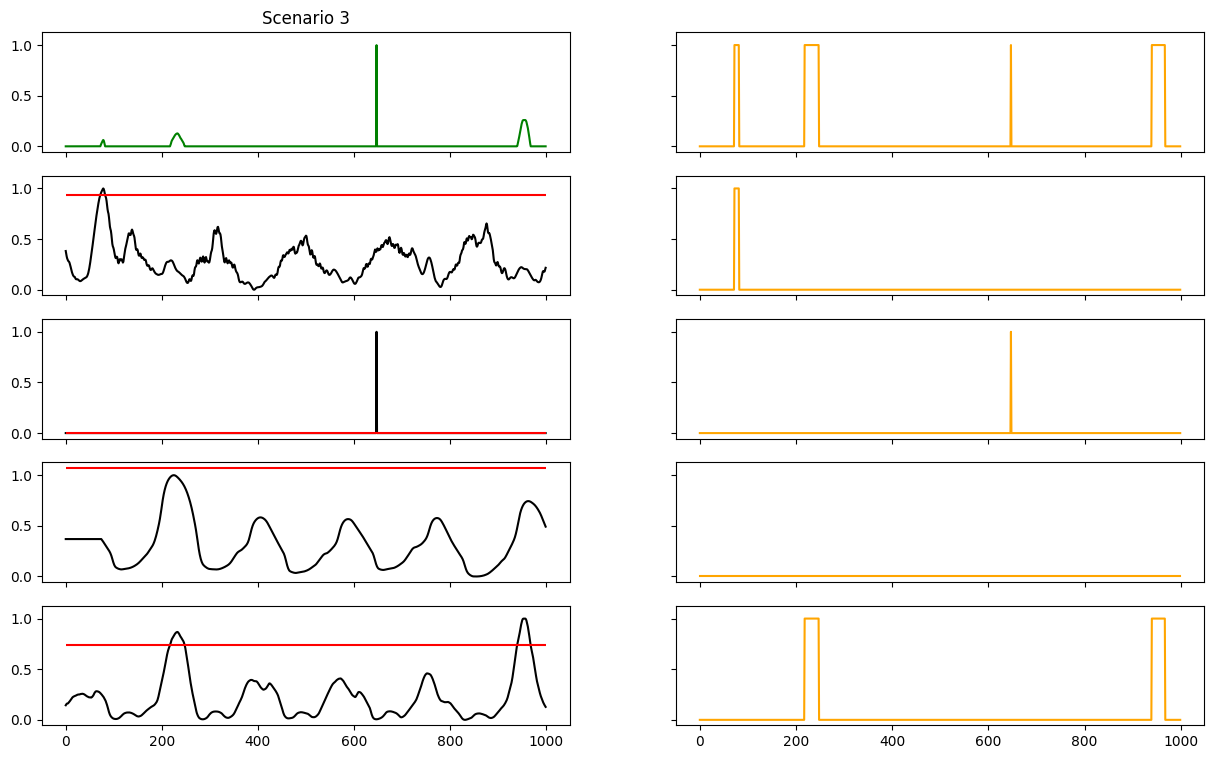

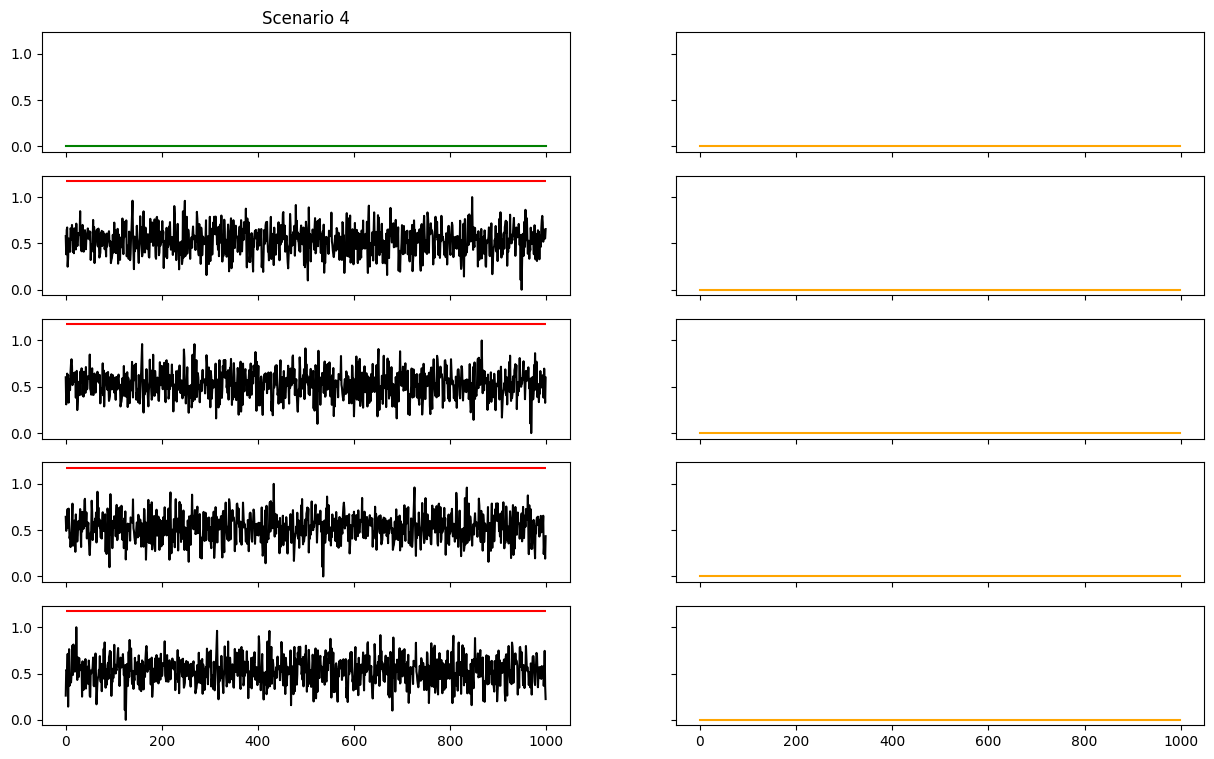

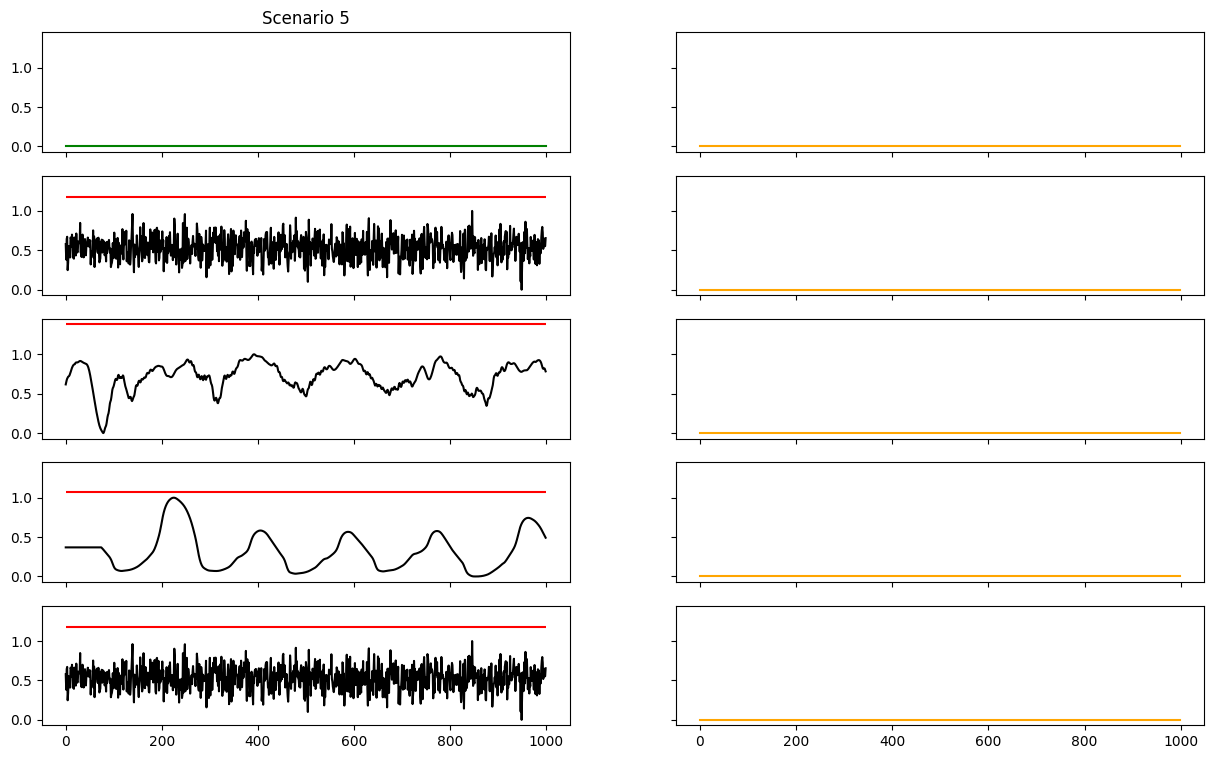

In [5]:
plot_scale = True
plot_predictions = True
# thresholding = SigmaThresholding(factor=2)
# thresholding = PyThreshThresholding(FILTER("hilbert"))
thresholding = PyThreshThresholding(MAD())


for i, sc in enumerate(scenarios):
    fig, axs = plt.subplots(sc.shape[0] + 1, 1+plot_predictions, sharex="col", sharey="all", squeeze=False)
    axs[0, 0].set_title(f"Scenario {i}")

    combined_predictions = np.zeros_like(sc[0, :], dtype=np.bool_)
    for i in range(sc.shape[0]):
        s = sc[i, :]
        if plot_scale:
            s = MinMaxScaler().fit_transform(s.reshape(-1, 1)).ravel()
        axs[i+1, 0].plot(s, color="black")
        if plot_predictions:
            t = thresholding
            predictions = t.fit_transform(np.zeros_like(s, dtype=np.int_), s)
            combined_predictions = np.bitwise_or(combined_predictions, predictions)
            axs[i+1, 0].hlines([t.threshold], 0, s.shape[0], color="red")
            axs[i+1, 1].plot(predictions, color="orange")

    combined_scores = aggregate_scores(sc.T, thresholding)
    axs[0, 0].plot(combined_scores, color="green")

    if plot_predictions:
        axs[0, 1].plot(combined_predictions, color="orange")
    plt.show()

## Gaussian scaling and aggregation

- Test different scaling methods
- Apply my and standard (max) aggregation

In [10]:
df = generate_intro_example_data()
instances = [
    ("subsequence_lof", {"window_size": 3}),
    # ("dwt_mlead", {}),
    ("grammarviz", {}),
    ("kmeans", {"window_size": 20}),
]
df_results = run_algorithms_on(df["value"].values, instances)
df_results


,subsequence_lof,grammarviz,kmeans
0,1.012395,0.662051,0.200350
1,1.018372,0.662051,0.437355
2,1.053987,0.662051,0.343593
3,1.050275,0.662051,0.315609
4,1.054462,0.662051,0.323978
...,...,...,...
4995,1.097153,0.592814,0.376622
4996,1.038016,0.592814,0.373836
4997,1.027205,0.592814,0.388866
4998,1.025337,0.592814,0.454457


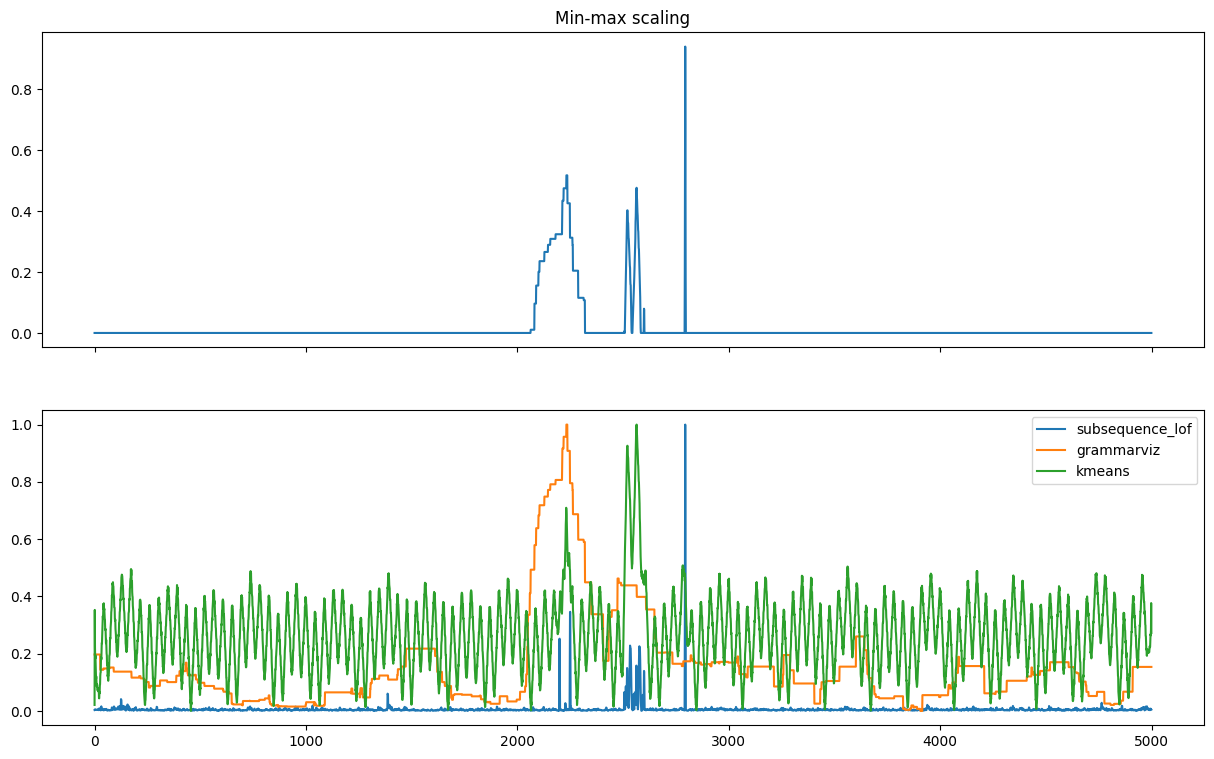

In [11]:
scores = df_results.values

# Min-max-scaling
min_max_scores = MinMaxScaler().fit_transform(scores)

fig, axs = plt.subplots(2, 1, sharex="col")
axs[0].set_title("Min-max scaling")
axs[0].plot(aggregate_scores(min_max_scores))
axs[1].plot(min_max_scores, label=df_results.columns)
plt.legend()
plt.show()


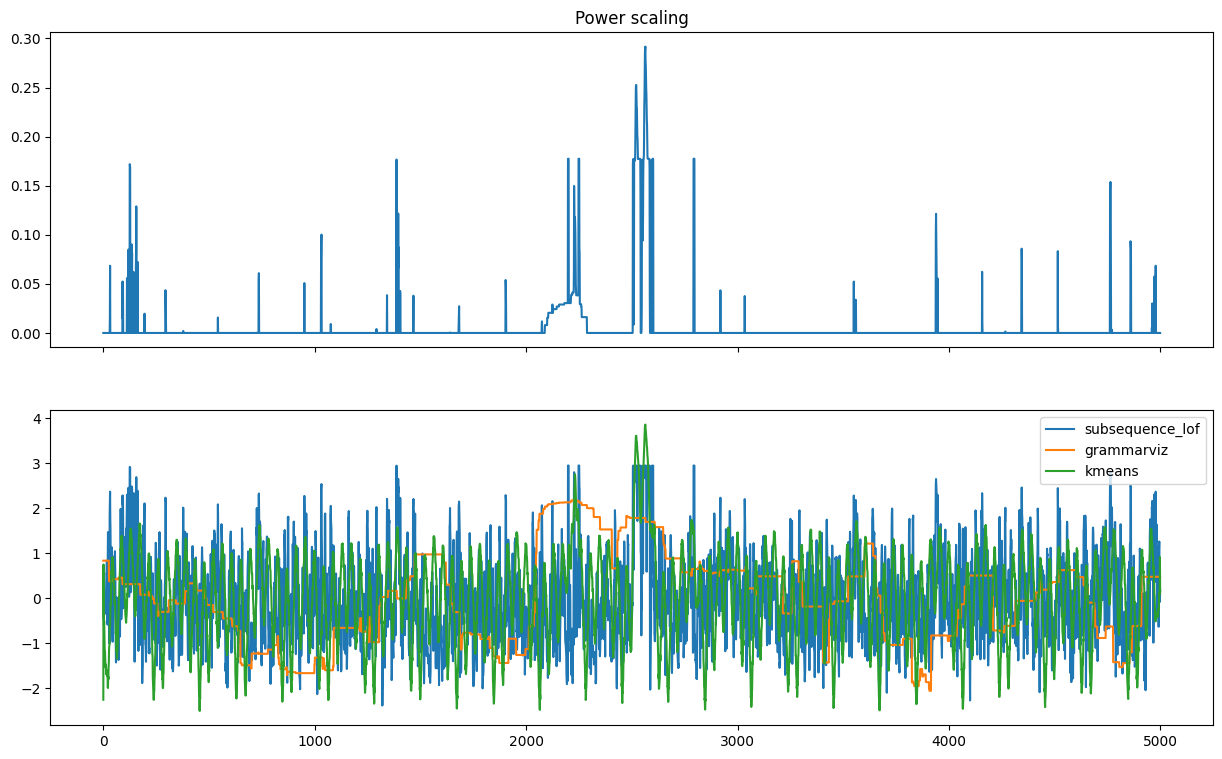

In [12]:
# Power scaling
power_scores = PowerTransformer().fit_transform(scores)

fig, axs = plt.subplots(2, 1, sharex="col")
axs[0].set_title("Power scaling")
axs[0].plot(aggregate_scores(power_scores))
axs[1].plot(power_scores, label=df_results.columns)
plt.legend()
plt.show()


In [16]:
from scipy.special import erf
import warnings
from typing import Optional


# Gaussian scaling
def regularize(x: np.ndarray, base_scores: Optional[np.ndarray] = None, linear_inverse: bool = False,
               log_inverse: bool = False) -> np.ndarray:
    if log_inverse:
        if np.min(x, axis=0) > 0:
            return - np.log(x / np.max(x, axis=0))
        else:
            warnings.warn(
                "Logarithmic inverse scaling is not possible for values <= 0. Using linear inverse scaling instead.")
            linear_inverse = True

    if linear_inverse:
        return np.max(x, axis=0) - x

    if base_scores is None:
        base_scores = np.median(x, axis=0)
    elif np.any(np.isnan(base_scores)):
        base_scores[np.isnan(base_scores)] = np.median(x[:, np.isnan(base_scores)], axis=0)

    result = x - base_scores
    result[result < 0] = 0
    return result


def gaussian_scale(x: np.ndarray) -> np.ndarray:
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)

    result = erf((x - mean) / (std * np.sqrt(2)))
    result[result < 0] = 0
    return result


# s = regularize(scores)
s = gaussian_scale(scores)


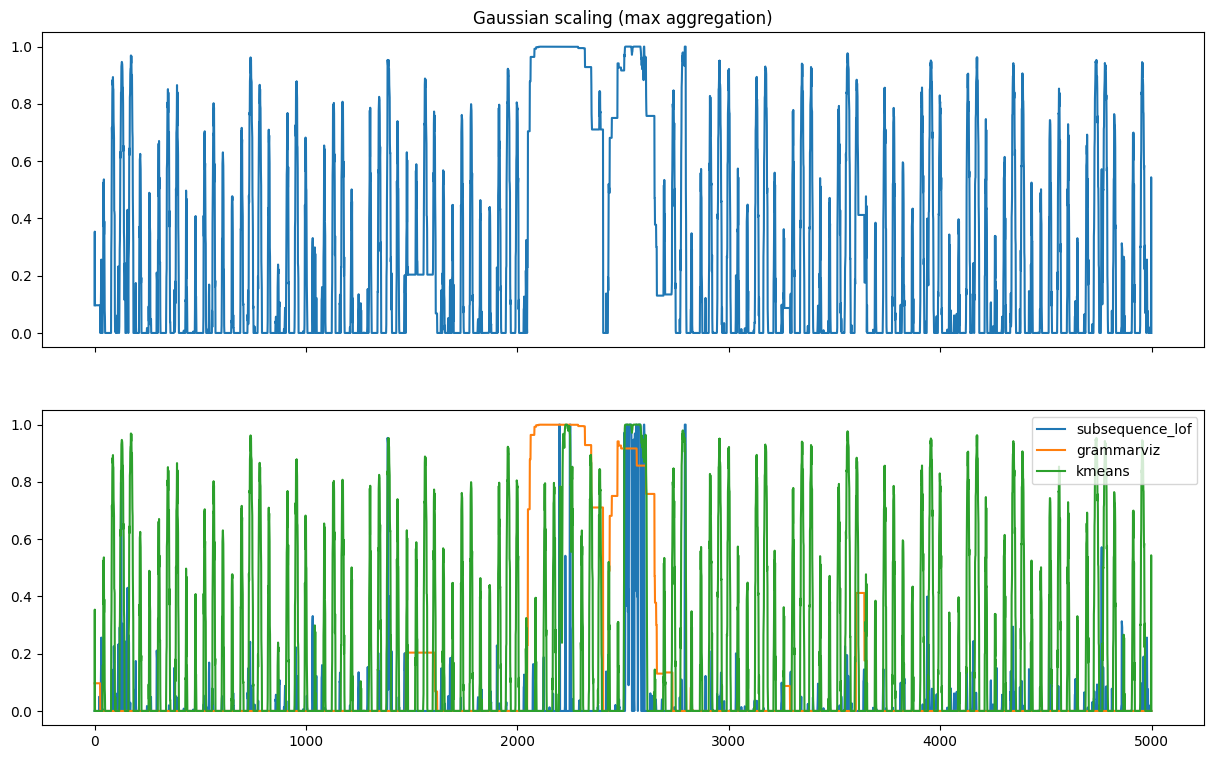

In [14]:
fig, axs = plt.subplots(2, 1, sharex="col")
axs[0].set_title("Gaussian scaling (max aggregation)")
axs[0].plot(np.max(s, axis=1))
axs[1].plot(s, label=df_results.columns)
plt.legend()
plt.show()


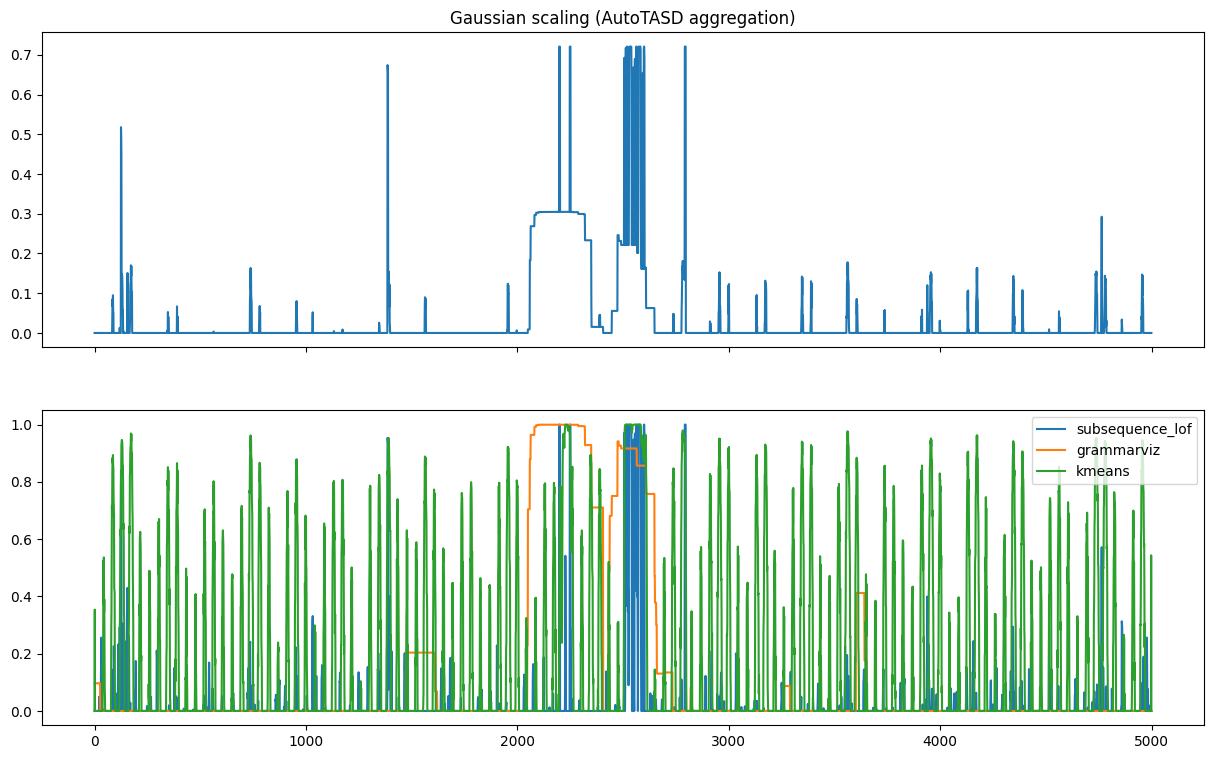

In [15]:
fig, axs = plt.subplots(2, 1, sharex="col")
axs[0].set_title("Gaussian scaling (AutoTASD aggregation)")
axs[0].plot(aggregate_scores(s))
axs[1].plot(s, label=df_results.columns)
plt.legend()
plt.show()
